#%_ Bloque de introducción

# Datasets
## Preparación
### Librerías

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


### Función de descarga
#%_ blablabla


In [2]:
def load_dataset(dataset_url: str, separator: str = '\s+', class_position: int = None, remove: list = None):
    """Load a dataset from a specified url into a pandas DataFrame.

    :param str dataset_url: an url from archive.ics.uci.edu
    :param str separator: file separator.
    :param int class_position: column index where classes are defined (starts by 0)
       if left empty (None), no prediction class will be used (intrinsic case).
    :param list remove: attributes indexes to remove.
    """
    # Load dataset as a pandas DataFrame from a specified url.
    dataset = pd.read_csv(dataset_url, sep=separator, header=None)

    # Extrinsic case, dataset comes with its classes.
    if class_position is not None:
        # Extract classes.
        classes = dataset.iloc[:, class_position]
        # Add class index to the indexes to remove.
        remove = [class_position] if remove is None else remove + [class_position]

    # Intrinsic case, dataset has no classes.
    else:
        classes = None

    # Remove noise attributes.
    if remove is not None:
        dataset.drop(remove, axis=1, inplace=True)

    # Force all values to be numeric.
    for (column, values) in dataset.iteritems():
        # Coerce transforms non-numeric values into NaN.
        dataset[column] = pd.to_numeric(values, errors='coerce')

    # Remove all NaN rows.
    # TODO: this might result in different classes vs attribute sizes. To be reviewed.
    dataset.dropna(inplace=True)

    return classes, dataset


### Función de visualización
#%_ blablabla
#%_ la idea es que esta función sea parametrizable y que pueda colorear los clusters


In [3]:
def plot_dataset(dataset: pd.DataFrame, classes: np.array = None) -> None:
    if classes is not None:
        dataset['classes'] = classes
        sns.pairplot(dataset, hue='classes')
    else:
        sns.pairplot(dataset)


## Selección


### Dataset extrínseca
#%_ los cilindros están en posición 1 (partiendo de 0)
#%_ no los he eliminado para que veamos el hue

In [4]:
dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
extrinsic_classes, extrinsic_dataset = load_dataset(dataset_url, class_position=1, remove=[7, 8])

In [5]:
plot_dataset(extrinsic_dataset, extrinsic_classes)

#%_ blablabla

## Dataset intrínseca

#%_ Hemos escogido el dataset *tae.csv*. Este trata de XXX con los atributos siguientes:
#%_ - aaa1
#%_ - aaa2
#%_ - ...

#%_ Cargamos nuestro dataset (*intrinsic_dataset*):

In [6]:
dataset_url = 'https://raw.githubusercontent.com/Grupo-MasterAI-ANS/actividad/master/datasets/tae.csv'
_, intrinsic_dataset = load_dataset(dataset_url, separator=',')

#%_ Podemos ver la relación siguiente entre atríbutos:

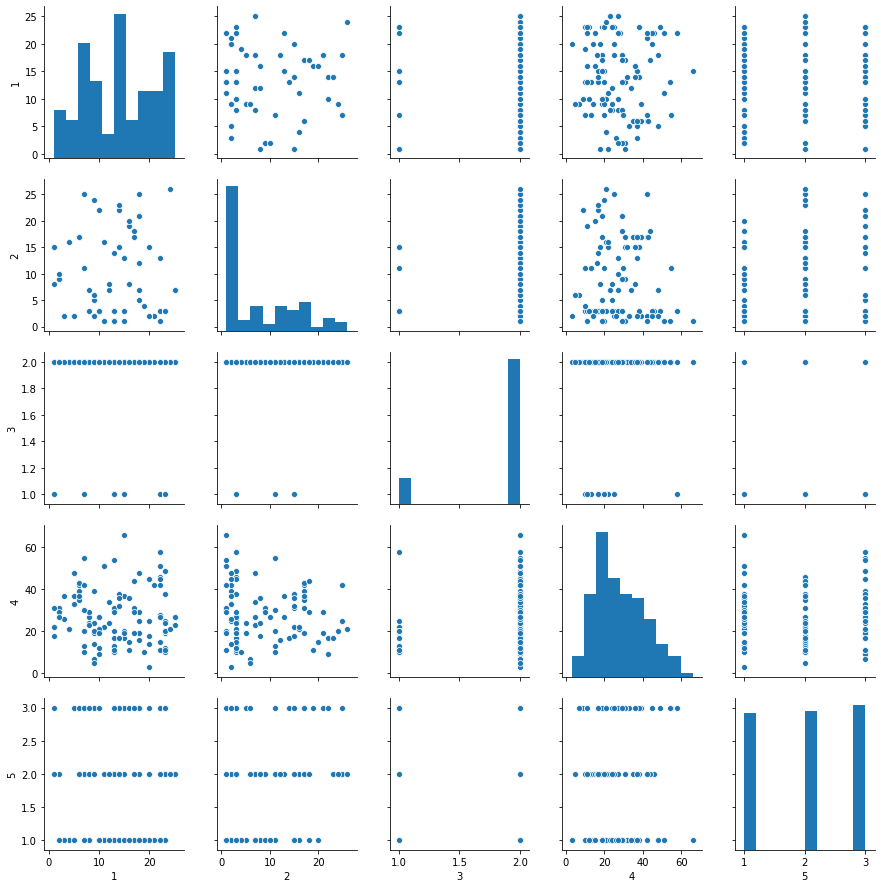

In [7]:
plot_dataset(intrinsic_dataset)


#%_ blablabla

# Análisis dataset extrínseca
## Algoritmos

### Algoritmo k-means
#### Selección del número de clusters

In [ ]:
def r2_score(dataset, prediction, centroids):
    """
    An intrinsic R² score metric, as sklearn one is extrinsic only.
    """
    attributes_mean = np.mean(dataset, axis=0)
    labels = np.sort(np.unique(prediction))
    numerator = np.sum([
        np.sum(np.sum(dataset[prediction == label] - centroids[label], axis=1) ** 2)
        for label in labels
    ])
    denominator = np.sum(np.sum(dataset - attributes_mean, 1) ** 2)

    return 1 - numerator / denominator


In [ ]:
def kmeans_plot_clusters_selection(dataset: pd.DataFrame, max_clusters: int = 10):
    dataset = np.array(dataset)
    silhouette_values = []
    r2_values = []
    min_clusters = 2

    for k in np.arange(min_clusters, max_clusters):
        model = KMeans(n_clusters=k).fit(dataset)
        prediction = model.predict(dataset)
        centroids = model.cluster_centers_

        silhouette_values += [metrics.silhouette_score(dataset, prediction)]
        r2_values += [r2_score(dataset, prediction, centroids)]

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.arange(min_clusters, max_clusters), silhouette_values, linestyle='-', marker='o')
    ax[0].set_xlabel("Número de clústeres")
    ax[0].set_ylabel("Medida de ancho de silueta")

    ax[1].plot(np.arange(min_clusters, max_clusters), r2_values, linestyle='-', marker='o')
    ax[1].set_xlabel("Número de clústeres")
    ax[1].set_ylabel("Medida de R cuadrado")


In [ ]:
kmeans_plot_clusters_selection(extrinsic_dataset)

### Algoritmo 2

### Algoritmo 3

### Algoritmo 4

### Algritmo 5

## Comparación algoritmos

# Análisis dataset intrínseca
## Algoritmos

### Algoritmo k-means

### Algoritmo 2

### Algoritmo 3

### Algoritmo 4

### Algoritmo 5

## Comparación algoritmos

# Conclusión